In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from umap import UMAP

import models
from data_frame import DataFrame, MaxFiller, MAGNITUDES, COLORS
from histogram_plotter import HistPlotter
from utils import load_config, load_model

DATAPATH = "../dataframes/experiment3/MG_3_components_3.csv"

df = pd.read_csv(DATAPATH, index_col=0)
df, indices = df.loc[(df["split"] == "test")], df.index
columns_100 = df.columns[-100:]

<b>Wykresy korelacji</b>

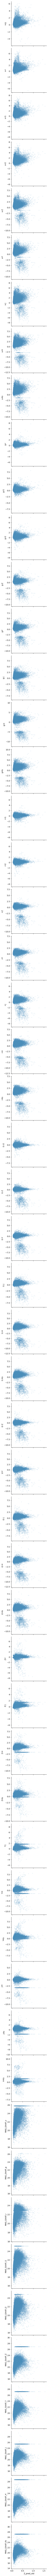

In [4]:
sns.pairplot(df, x_vars=["Z_pred_std"], y_vars=COLORS + MAGNITUDES, kind="scatter", height=3.5, plot_kws=dict(s=15, alpha=0.1))

<b>Redukcja wymiarów T-sne + Clustering HDBSCAN</b>

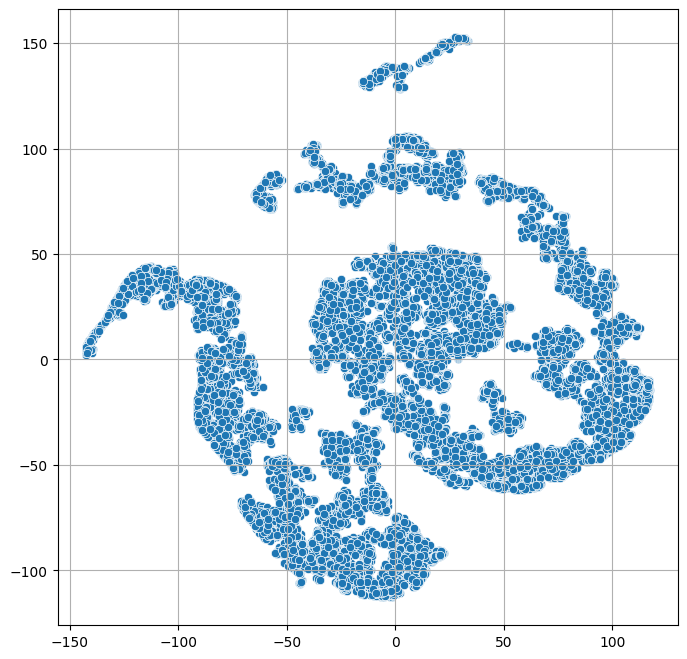

In [64]:
X_scaled = StandardScaler().fit_transform(df[columns_100])
X_emb = TSNE(n_components=2, perplexity=50, learning_rate=200, max_iter=5000,
             init="random", metric="correlation", random_state=0, n_jobs=-1).fit_transform(X_scaled)

plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1])
plt.grid()
plt.show()

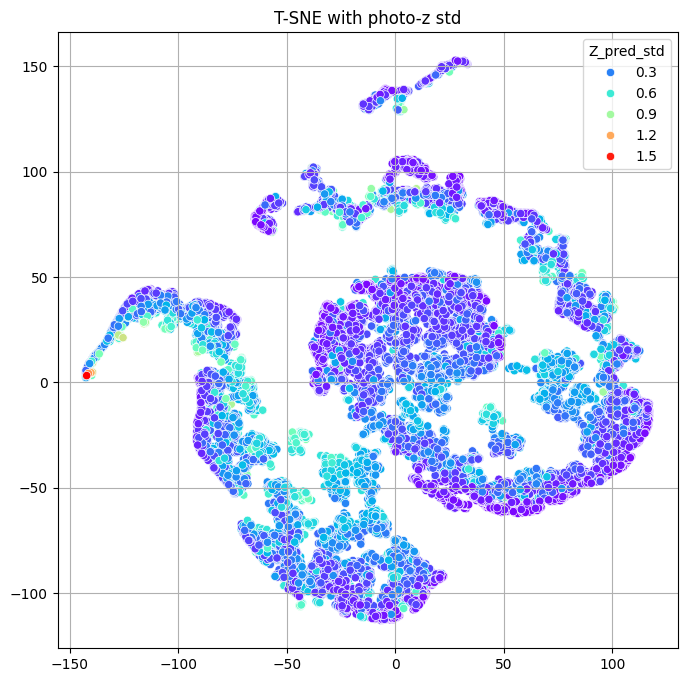

In [65]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=df["Z_pred_std"], palette="rainbow")
plt.grid()
plt.title("T-SNE with photo-z std")
plt.show()

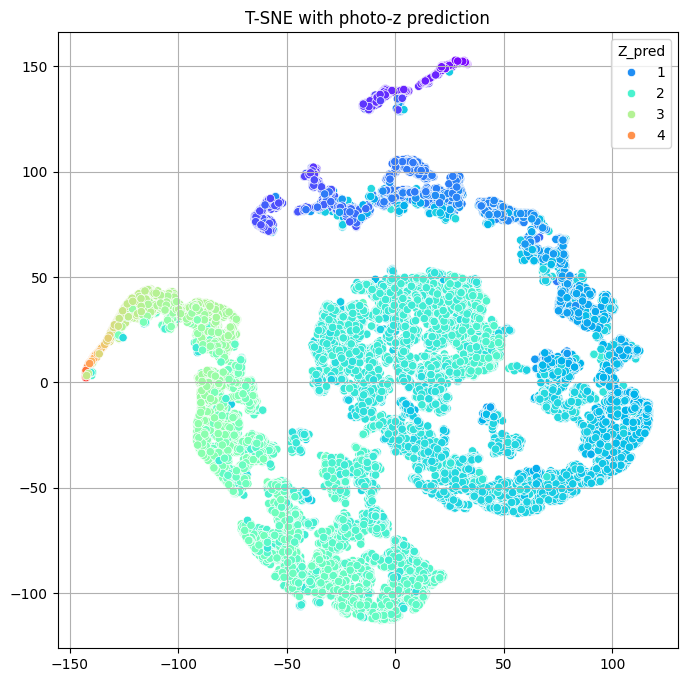

In [66]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=df["Z_pred"], palette="rainbow")
plt.grid()
plt.title("T-SNE with photo-z prediction")
plt.show()

0  
 9     8981
 4     4215
 5     1848
 6     1679
 2     1629
 7     1161
 10     711
 0      555
 8      439
-1      376
 1      287
 3      284
Name: count, dtype: int64


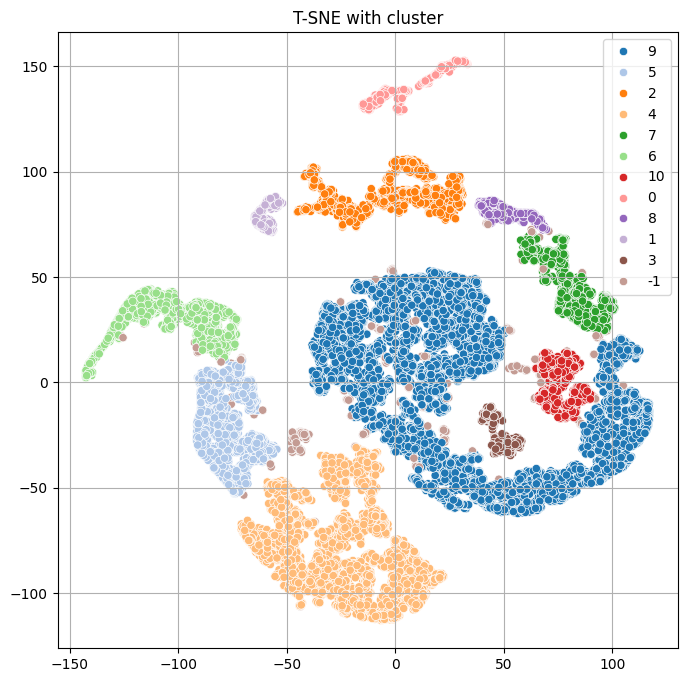

In [67]:
clusters = HDBSCAN(min_cluster_size=260, min_samples=30, metric="euclidean").fit_predict(X_emb)

print(pd.DataFrame(clusters).value_counts())

plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=clusters.astype(str), palette="tab20")
plt.grid()
plt.title("T-SNE with cluster")
plt.show()

<b>Redukcja wymiarów UMAP + Clustering HDBSCAN</b>

/home/kdrabicki/anaconda3/envs/cpu_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


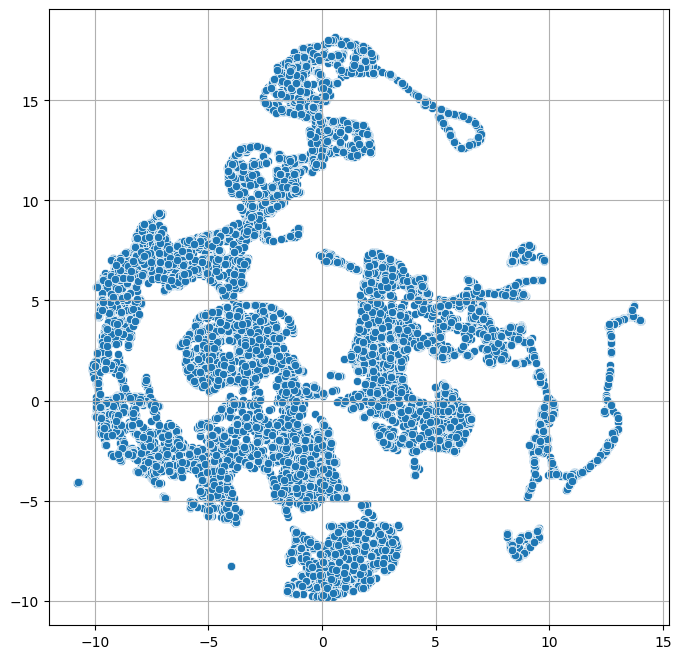

In [57]:
X_scaled = StandardScaler().fit_transform(df[columns_100])
X_emb = UMAP(n_neighbors=10, min_dist=0.05, metric="correlation", random_state=42, n_jobs=-1).fit_transform(X_scaled)

plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1])
plt.grid()
plt.show()

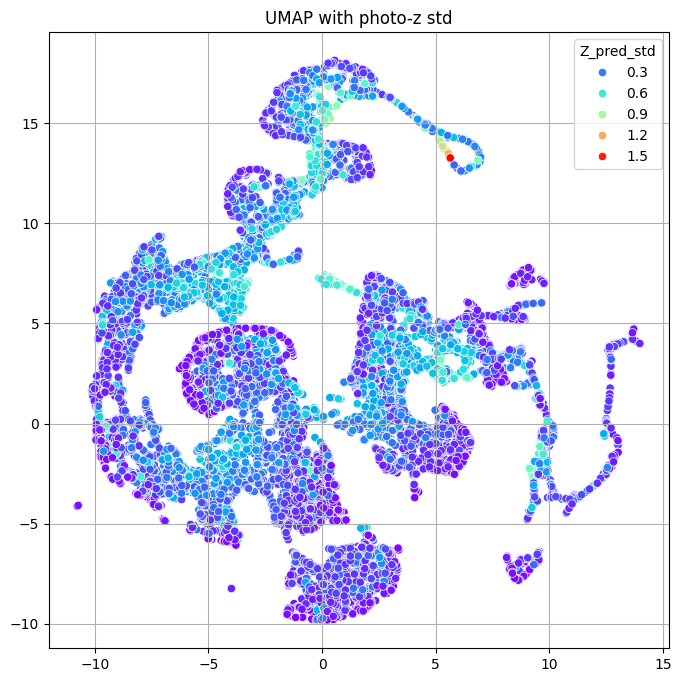

In [58]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=df["Z_pred_std"], palette="rainbow")
plt.grid()
plt.title("UMAP with photo-z std")
plt.show()

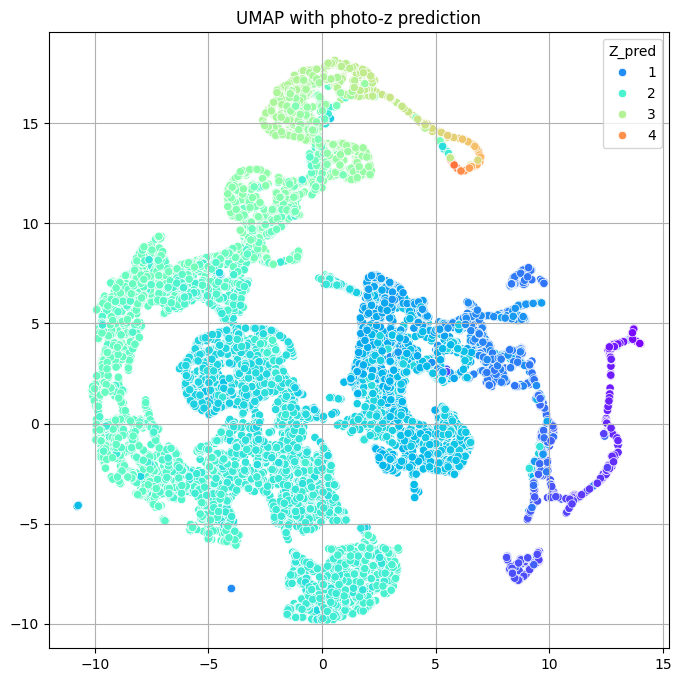

In [59]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=df["Z_pred"], palette="rainbow")
plt.grid()
plt.title("UMAP with photo-z prediction")
plt.show()

(22165, 100)
0 
 2    12435
 4     5301
 3     2103
-1      975
 5      481
 1      321
 0      285
 6      264
Name: count, dtype: int64


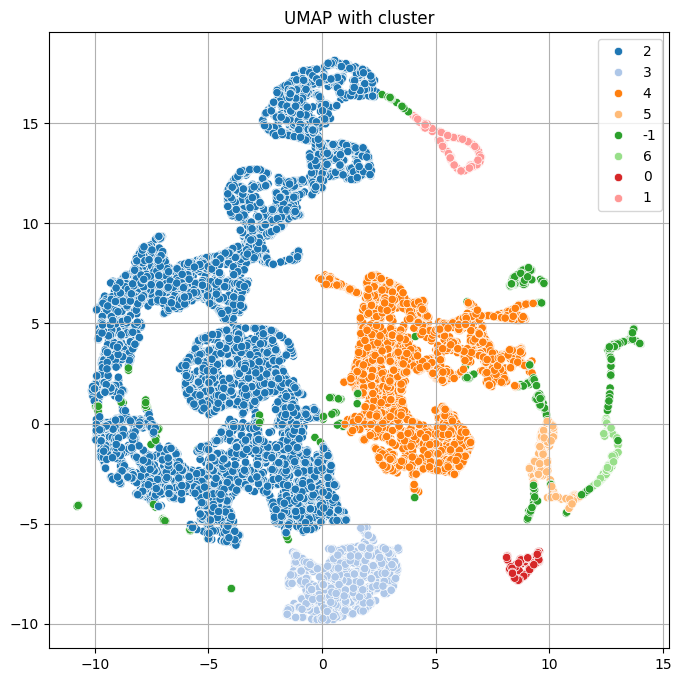

In [61]:
clusters = HDBSCAN(min_cluster_size=200, min_samples=50, metric="euclidean").fit_predict(X_emb)
print(X_scaled.shape)
print(pd.DataFrame(clusters).value_counts())

plt.figure(figsize=(8,8))
sns.scatterplot(x=X_emb[:, 0], y=X_emb[:, 1], hue=clusters.astype(str), palette="tab20")
plt.grid()
plt.title("UMAP with cluster")
plt.show()

<b>Histogramy clustrów</b>

In [68]:
config_path = "configs/config.yml"
config = load_config(config_path)

filePath = "../KiDS-DR5-WCScut_x_DESI-DR1-small.fits"

dframe = DataFrame(filePath, "QSO", MaxFiller())
X_train, y_train = dframe.get_train_dataset()
features = dframe.features

scaler = StandardScaler()
scaler.fit(X_train)

modelPath = f"../models/experiment2/MG_{config["num_components"]}_components_3/variables/variables"
model = load_model(modelPath, models.MixtureGaussian, dframe, config)

Chi^2: 1413.102914926582


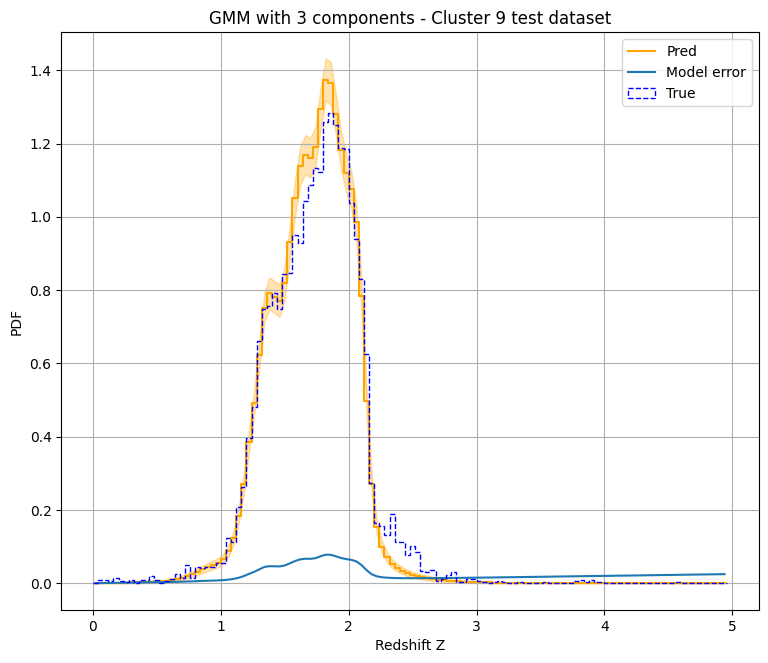

Chi^2: 1444.805864825214


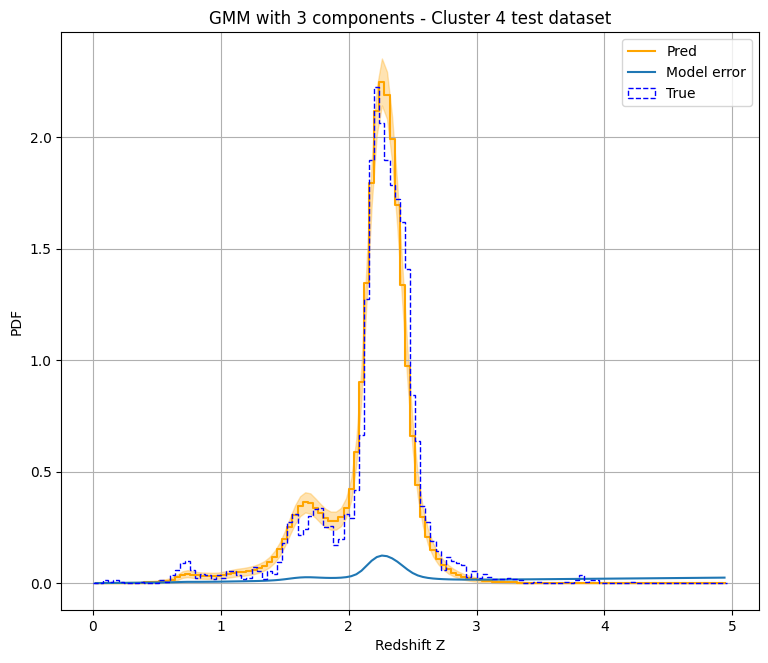

Chi^2: 1110.533149714523


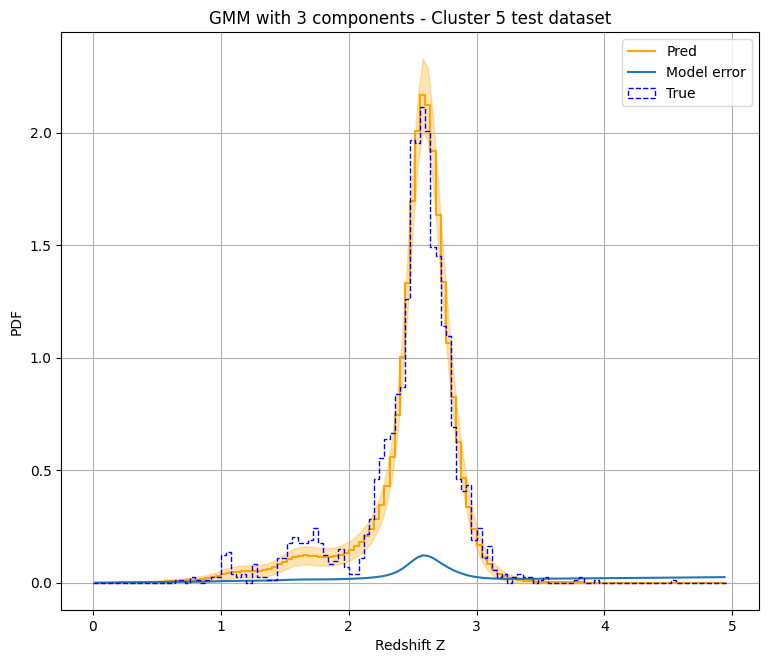

Chi^2: 2405.2002514540964


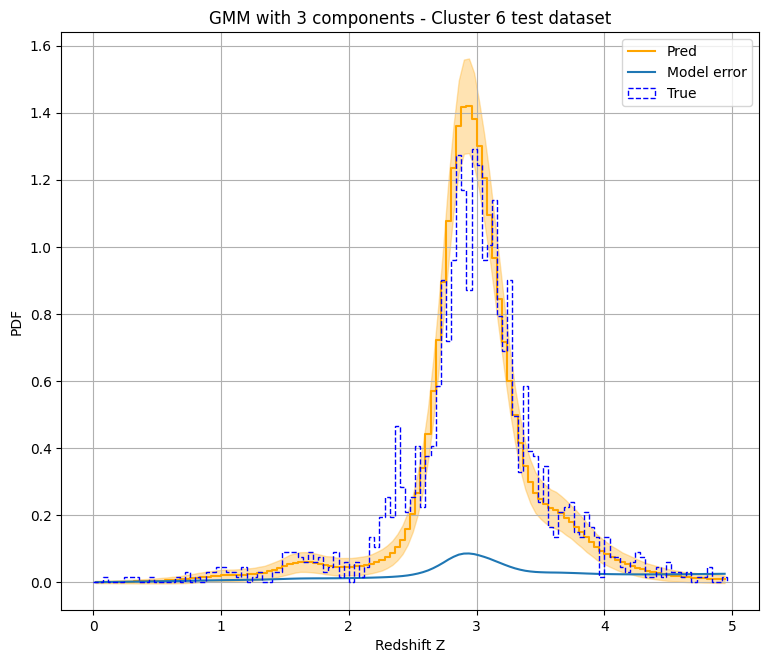

Chi^2: 1819.8454647884666


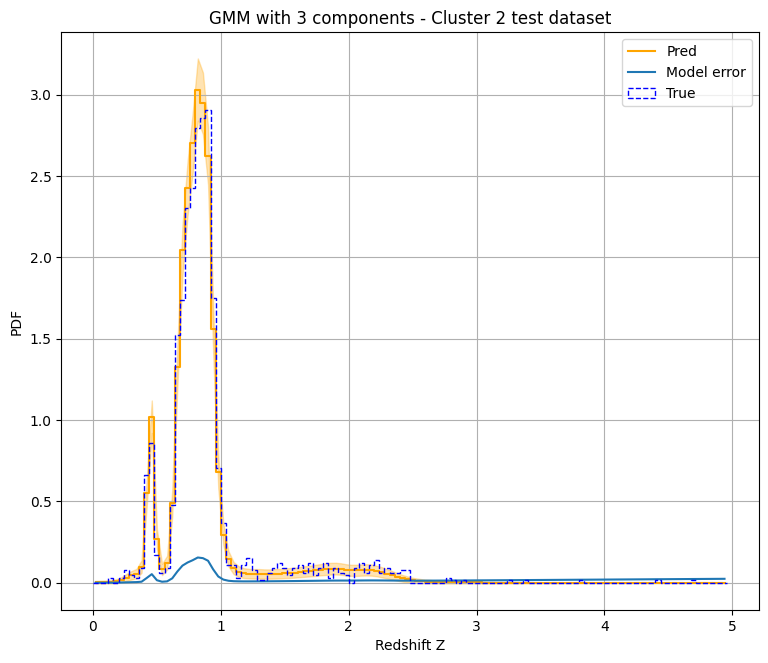

Chi^2: 4669.682346701587


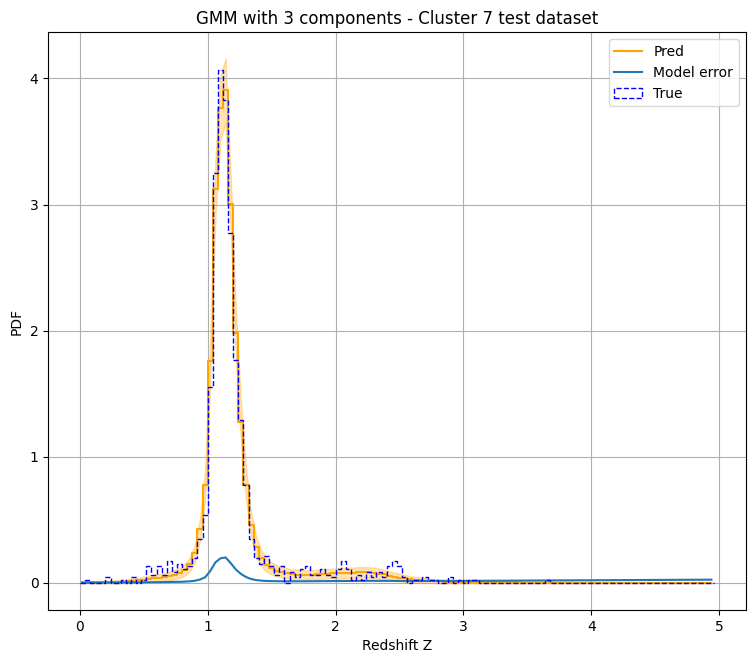

Chi^2: 6804.034581958655


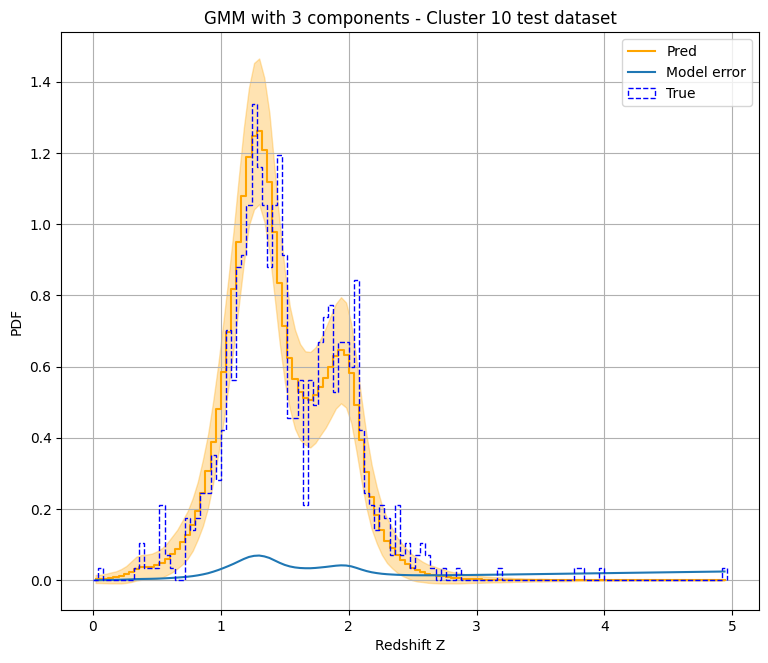

Chi^2: 1815.7364930586039


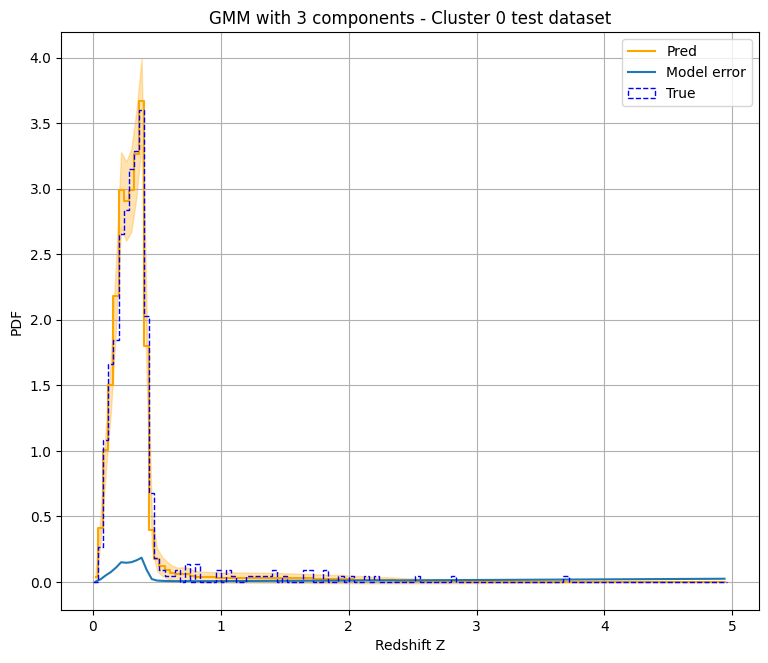

Chi^2: 2916.0976831701582


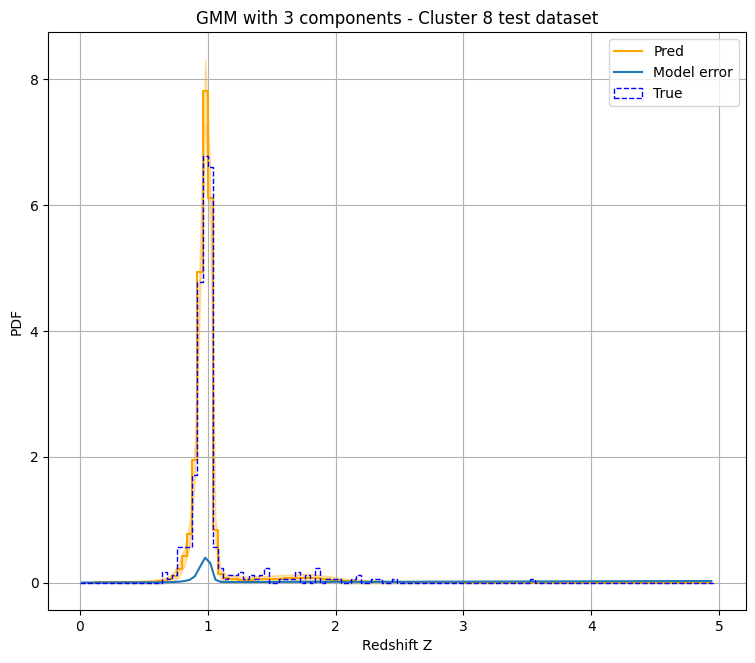

Chi^2: 8073.109436162529


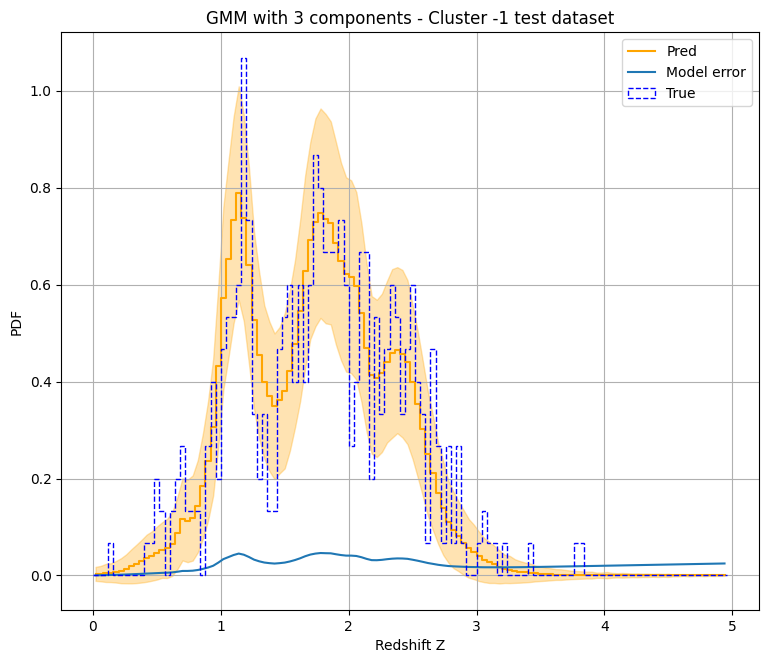

Chi^2: 6940.644790592187


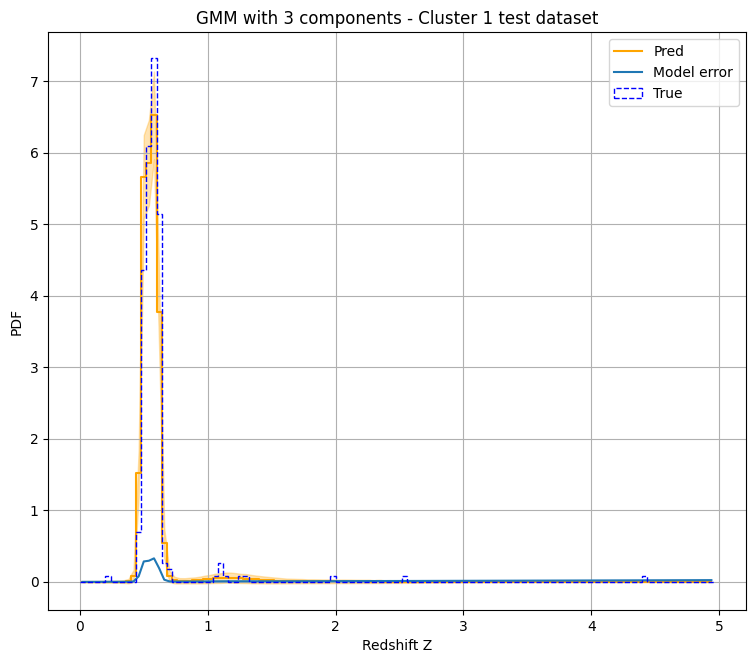

Chi^2: 4621.656233707832


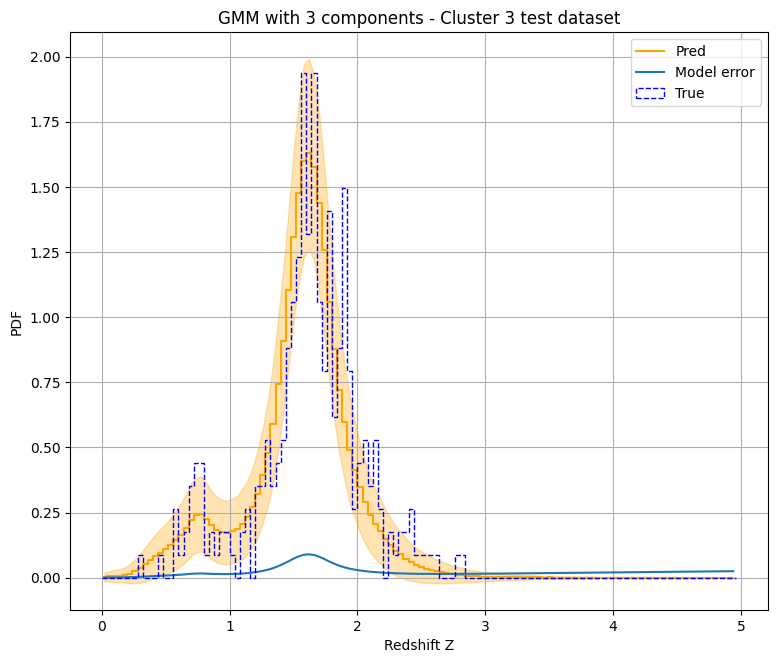

In [69]:
df["cluster"] = clusters
clusters = df["cluster"].value_counts().index.values

def return_cluster(df, cluster_num):
    df = df.loc[df["cluster"] == cluster_num]
    X, y = df.loc[:, features], df.loc[:, "Z"]
    X = scaler.transform(X)
    return X, y

for cluster in clusters:
    X, y = return_cluster(df, cluster)
    histPlotter = HistPlotter(X, y, f"Cluster {cluster}", model, "GMM")
    histPlotter.evaluate_model()